In [1]:
import numpy as np
import pandas as pd
import math

import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from pytorch_lightning import seed_everything
seed_everything(42, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)


import dcor

from datetime import datetime

from torch import nn

import argparse

import os 

import time
from time import process_time



[rank: 0] Global seed set to 42


In [2]:
x_train=pd.read_csv("./application-data/x_train.csv")
x_train=x_train.drop('Unnamed: 0', axis=1)
x_train=x_train.to_numpy()
x_test=pd.read_csv("./application-data/x_test.csv")
x_test=x_test.drop('Unnamed: 0', axis=1)
x_test=x_test.to_numpy()
y_train=pd.read_csv("./application-data/y_train.csv")
y_train=y_train.drop('Unnamed: 0', axis=1)
y_train=y_train.to_numpy()
y_test=pd.read_csv("./application-data/y_test.csv")
y_test=y_test.drop('Unnamed: 0', axis=1)
y_test=y_test.to_numpy()

In [3]:
l1=2
l2=2
r1=50
r2=100
res_d=1
m=50

In [4]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
t1_start = time.time() 
t2_start = process_time()

In [6]:
def kernel_func(bw, y1, y2):
    return math.exp(-((y1-y2)/bw)**2/2)

In [7]:
y_list=np.random.uniform(low=y_train.mean()-2*y_train.std(),
                         high=y_train.mean()+2*y_train.std(),
                         size=m)
bw=y_train.std()

In [8]:
y_trans_train=[]
for i in range(y_train.shape[0]):
    y_trans_current=[]
    for j in range(m):
        y_trans_current.append(kernel_func(bw,y_list[j],y_train[i][0]))
    y_trans_train.append(y_trans_current)
y_trans_train=np.array(y_trans_train)
y_trans_test=[]
for i in range(y_test.shape[0]):
    y_trans_current=[]
    for j in range(m):
        y_trans_current.append(kernel_func(bw,y_list[j],y_test[i][0]))
    y_trans_test.append(y_trans_current)
y_trans_test=np.array(y_trans_test)

In [9]:
#z_test[0,:]

In [10]:
n=x_train.shape[0]
p=x_train.shape[1]

y_train=y_train.reshape((n,1))
y_test=y_test.reshape((y_test.shape[0],1))

y_train_original=y_train
y_test_original=y_test


x_train = torch.tensor(x_train).to(torch.float)
x_test = torch.tensor(x_test).to(torch.float)
y_train = torch.tensor(y_trans_train).to(torch.float)
y_test = torch.tensor(y_trans_test).to(torch.float)


#print(x_train[:5],y_trans[:5])
mse_loss = nn.MSELoss()
# Build model
class nn_dr_reg_model(nn.Module):
    def __init__(self, input_features, output_features, dim_red_features, hidden_units_d, hidden_units_e, dim_red_layers, ens_reg_layers):
        super().__init__()
        model_dim_red=[]
        model_dim_red.append(nn.Linear(in_features=input_features, 
                                    out_features=hidden_units_d))
        model_dim_red.append(nn.ReLU())
        for i in range(1,dim_red_layers):
            model_dim_red.append(nn.Linear(in_features=hidden_units_d, 
                                        out_features=hidden_units_d))
            model_dim_red.append(nn.ReLU())
        model_dim_red.append(nn.Linear(in_features=hidden_units_d, 
                                    out_features=dim_red_features))
        self.dim_red_layer_stack = nn.Sequential(*model_dim_red)

        model_ens_reg=[]
        model_ens_reg.append(nn.Linear(in_features=dim_red_features, out_features=hidden_units_e))
        model_ens_reg.append(nn.ReLU())
        for i in range(1,ens_reg_layers):
            model_ens_reg.append(nn.Linear(in_features=hidden_units_e, out_features=hidden_units_e))
            model_ens_reg.append(nn.ReLU())
        model_ens_reg.append(nn.Linear(in_features=hidden_units_e, out_features=output_features))
        self.ens_reg_layer_stack = nn.Sequential(*model_ens_reg)

    def forward(self, x):
        suff_predictor = self.dim_red_layer_stack(x)
        ens_output = self.ens_reg_layer_stack(suff_predictor)
        return ens_output, suff_predictor


# Create an instance of BlobModel and send it to the target device
model_nn = nn_dr_reg_model(input_features=p, 
                        output_features=m, 
                        dim_red_features=res_d, 
                        hidden_units_d=r1,
                        hidden_units_e=r2,
                        dim_red_layers=l1, 
                        ens_reg_layers=l2
                        ).to(device)
model_nn
optimizer = torch.optim.Adam(model_nn.parameters(), 
                            lr=0.001)
epochs = 400
x_train, y_train = x_train.to(device), y_train.to(device)
x_test = x_test.to(device)
for epoch in range(epochs):
    ### Training
    model_nn.train()

    # 1. Forward pass
    y_pred_train, y_suff_train = model_nn(x_train) 

    # 2. Calculate loss and accuracy
    loss = mse_loss(y_pred_train, y_train) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_nn.eval()

    y_pred_test, y_suff_test = model_nn(x_test)
    loss_test = mse_loss(y_pred_test, y_test) 
    dcor_test = dcor.distance_correlation(np.float64(y_suff_test.detach().numpy()),np.float64(y_test))

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {loss_test:.5f} | Dcor: {dcor_test:.5f}")
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time =", current_time)
model_nn.eval()
with torch.inference_mode():
    y_pred_train, y_suff_train = model_nn(x_train)
    y_pred_test, y_suff_test = model_nn(x_test)
y_suff_train=y_suff_train.numpy()
y_suff_test=y_suff_test.numpy()

y_pred_train=y_pred_train.numpy()
y_pred_test=y_pred_test.numpy()



t1_stop = time.time() 
t2_stop = process_time()


print(dcor.distance_correlation(np.float64(y_suff_train),np.float64(y_train)),
     dcor.distance_correlation(np.float64(y_suff_test),np.float64(y_test)))


Epoch: 0 | Loss: 316.26495 | Test Loss: 90.77242 | Dcor: 0.58226
Current Time = 11:54:29
Epoch: 10 | Loss: 5.81091 | Test Loss: 4.22238 | Dcor: 0.29329
Current Time = 11:54:50
Epoch: 20 | Loss: 0.75395 | Test Loss: 0.63386 | Dcor: 0.48674
Current Time = 11:55:13
Epoch: 30 | Loss: 0.37805 | Test Loss: 0.35524 | Dcor: 0.49041
Current Time = 11:55:34
Epoch: 40 | Loss: 0.25897 | Test Loss: 0.24566 | Dcor: 0.50954
Current Time = 11:55:55
Epoch: 50 | Loss: 0.18045 | Test Loss: 0.17624 | Dcor: 0.49695
Current Time = 11:56:16
Epoch: 60 | Loss: 0.14323 | Test Loss: 0.14006 | Dcor: 0.45038
Current Time = 11:56:37
Epoch: 70 | Loss: 0.12551 | Test Loss: 0.12260 | Dcor: 0.44687
Current Time = 11:56:57
Epoch: 80 | Loss: 0.11558 | Test Loss: 0.11355 | Dcor: 0.44172
Current Time = 11:57:18
Epoch: 90 | Loss: 0.11051 | Test Loss: 0.10848 | Dcor: 0.42084
Current Time = 11:57:39
Epoch: 100 | Loss: 0.10763 | Test Loss: 0.10557 | Dcor: 0.45009
Current Time = 11:58:00
Epoch: 110 | Loss: 0.10514 | Test Loss: 

In [11]:
time_use=[t1_stop-t1_start,t2_stop-t2_start]
print(time_use)
time_use_df=pd.DataFrame(time_use)
time_use_df.to_csv("./application-results/time-1-50.csv")

[829.8127152919769, 1742.678915457]


In [12]:
#dcor_list_df
#dcor.distance_correlation(np.float64(y_suff_test),np.float64(z_test.to_numpy()[:,0]),method="naive")

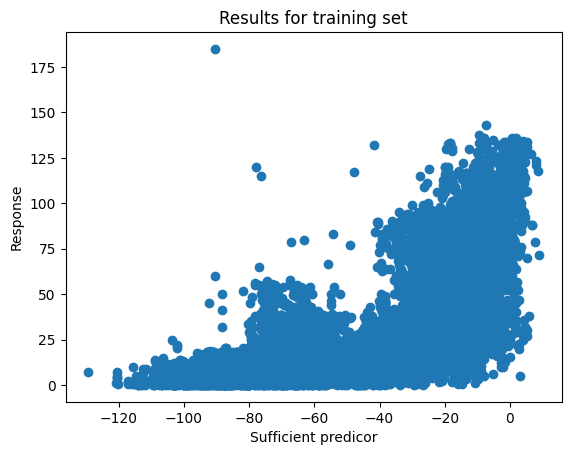

In [13]:
plt.plot(y_suff_train, y_train_original, 'o', color="C0")
plt.xlabel("Sufficient predicor")
plt.ylabel("Response")
plt.title("Results for training set")
plt.savefig("application-training-BENN-1-50.pdf", format="pdf", bbox_inches="tight")
plt.show()

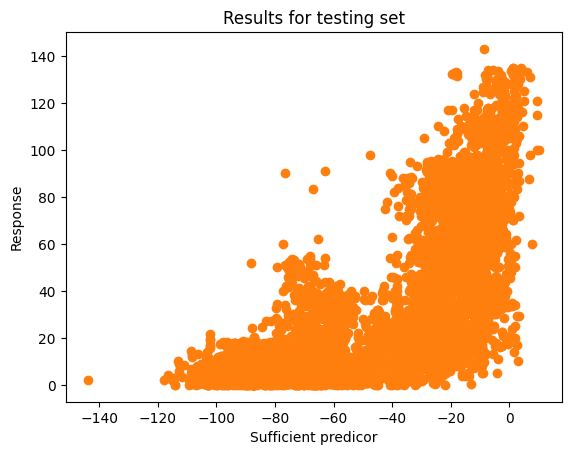

In [14]:
plt.plot(y_suff_test, y_test_original, 'o', color="C1")
plt.xlabel("Sufficient predicor")
plt.ylabel("Response")
plt.title("Results for testing set")
plt.savefig("application-testing-BENN-1-50.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [15]:
y_suff_train_df=pd.DataFrame(y_suff_train)
y_suff_test_df=pd.DataFrame(y_suff_test)
y_suff_train_df.to_csv("./application-results/y_suff_train_BENN-1-50.csv")
y_suff_test_df.to_csv("./application-results/y_suff_test_BENN-1-50.csv")

In [16]:
dcor_res=[dcor.distance_correlation(np.float64(y_suff_train),np.float64(y_train)),
          dcor.distance_correlation(np.float64(y_suff_test),np.float64(y_test))]
dcor_res_df=pd.DataFrame(dcor_res)
dcor_res_df.to_csv("./application-results/dcor_res_BENN-1-50.csv")

In [17]:
#dcor.distance_correlation(np.float64(y_suff_test.detach().numpy()),np.float64(z_test.to_numpy()),method="avl")

In [18]:
#dcor.distance_correlation(np.float64(y_suff_test.detach().numpy()),np.float64(z_test.to_numpy()),method="naive")